In [43]:
import numpy as np
import nibabel as nb
import pandas as pd
import os.path as op
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from matplotlib.gridspec import GridSpec
import statsmodels.formula.api as smf
import moss
%matplotlib inline

In [44]:
home_dir = op.abspath('../')

#plotting settings
fontsize = 18
ticksize = fontsize*.8
sns.set_context('talk')
sns.__version__

'0.13.2'

In [45]:
pet = pd.read_csv('./csvs/pet.csv')

In [46]:
lags = pd.read_csv('./csvs/lags_pet_rois.csv')
lags = lags.rename(columns = {'mask':'roi'})
lags['sub'] = [int(x[2:]) for x in lags['sub']]
lags = lags[lags['sub'] != 216]
lags['lag'] = lags['lag']*1000

In [47]:
## genetic data
genes = pd.read_csv(op.abspath('./csvs/gene_codes.csv'))[['subject','DRD2','COMT']]
genes['sub'] = genes['subject']
genes = genes.groupby(['sub','COMT','DRD2']).mean().reset_index()

comt_map = {'Met':'Met/Met',
           'Val':'Val/Val'}
genes['COMT'] = [comt_map[x] for x in genes['COMT']]


lags = pd.merge(lags,
        genes,
         'left',
        on = 'sub')

In [48]:
#exclude bad subjects
lags = lags[lags['sub'] != 220]
lags = lags[lags['sub'] != 395]
len(set(lags['sub']))
len(set(lags['sub']))

73

In [49]:
#merge pet and lag data
for pet_id in ['fmt','rac','rac2']:
    
    fmt = pd.melt(pet,
           id_vars = ['sub'],
           value_vars = ['VST_' +pet_id,'DCA_' + pet_id,'DPUT_' +pet_id],
           value_name = pet_id)

    fmt['roi'] = [x.split('_')[0] for x in fmt['variable']]
    fmt = fmt[['sub',pet_id,'roi']]


    lags = pd.merge(fmt,
            lags,
            how = 'outer',
            on = ['sub','roi'])
lags = lags.dropna(subset = ['lag'])

In [50]:
lags = moss.remove_unit_variance(lags,'lag','sub', group = ['roi','DRD2','COMT'])

In [51]:
#rename columns
drug_map = {'plac':'Placebo','brom':'Bromocriptine','tolc':'Tolcapone'}
lags['Drug'] = [drug_map[x] for x in lags['drug']]
lags['dopamine synthesis capacity'] = lags['fmt']

roi_map = {'VST':'NAcc',
          'DCA':'Caudate',
          'DPUT':'Putamen',
          'S1':'S1',
          'OT':'OTC'}
lags[''] = [roi_map[x] for x in lags['roi']]

In [52]:
#compute delta on drugs
means = lags.groupby(['sub','DRD2','COMT','drug','roi'])['lag'].mean().reset_index()
means = means.set_index(['sub','roi']).sort_index()

means_df = []
for sub,roi in set(means.index):
    
    sub_df = means.loc[(sub,roi)].copy()
    
    brom_diff = float(sub_df.loc[sub_df['drug'] == 'brom','lag'] - sub_df.loc[sub_df['drug'] == 'plac','lag'])
    tolc_diff = float(sub_df.loc[sub_df['drug'] == 'tolc','lag'] - sub_df.loc[sub_df['drug'] == 'plac','lag'])
    
    means_df.append(pd.DataFrame({'sub':sub,
                                 'roi':roi_map[roi],
                                 'brom_diff':brom_diff,
                                  'tolc_diff':tolc_diff,
                                 'DRD2':sub_df['DRD2'].values[0],
                                 'COMT':sub_df['COMT'].values[0]},index = [0]))
means_df = pd.concat(means_df)

/var/folders/bn/dzh1ysw54m9cq4n3dnb30ldw0000gn/T/ipykernel_9148/3852835769.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  brom_diff = float(sub_df.loc[sub_df['drug'] == 'brom','lag'] - sub_df.loc[sub_df['drug'] == 'plac','lag'])
/var/folders/bn/dzh1ysw54m9cq4n3dnb30ldw0000gn/T/ipykernel_9148/3852835769.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tolc_diff = float(sub_df.loc[sub_df['drug'] == 'tolc','lag'] - sub_df.loc[sub_df['drug'] == 'plac','lag'])


In [53]:
drug_diff = lags.sort_values(by = ['drug','sub','roi'])
drug_diff = drug_diff.set_index('drug')
drug_diff.loc['brom','lag_diff']= drug_diff.loc['brom','lag'].values -  drug_diff.loc['plac','lag'].values
drug_diff  = drug_diff.reset_index()

# Make figure

In [54]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

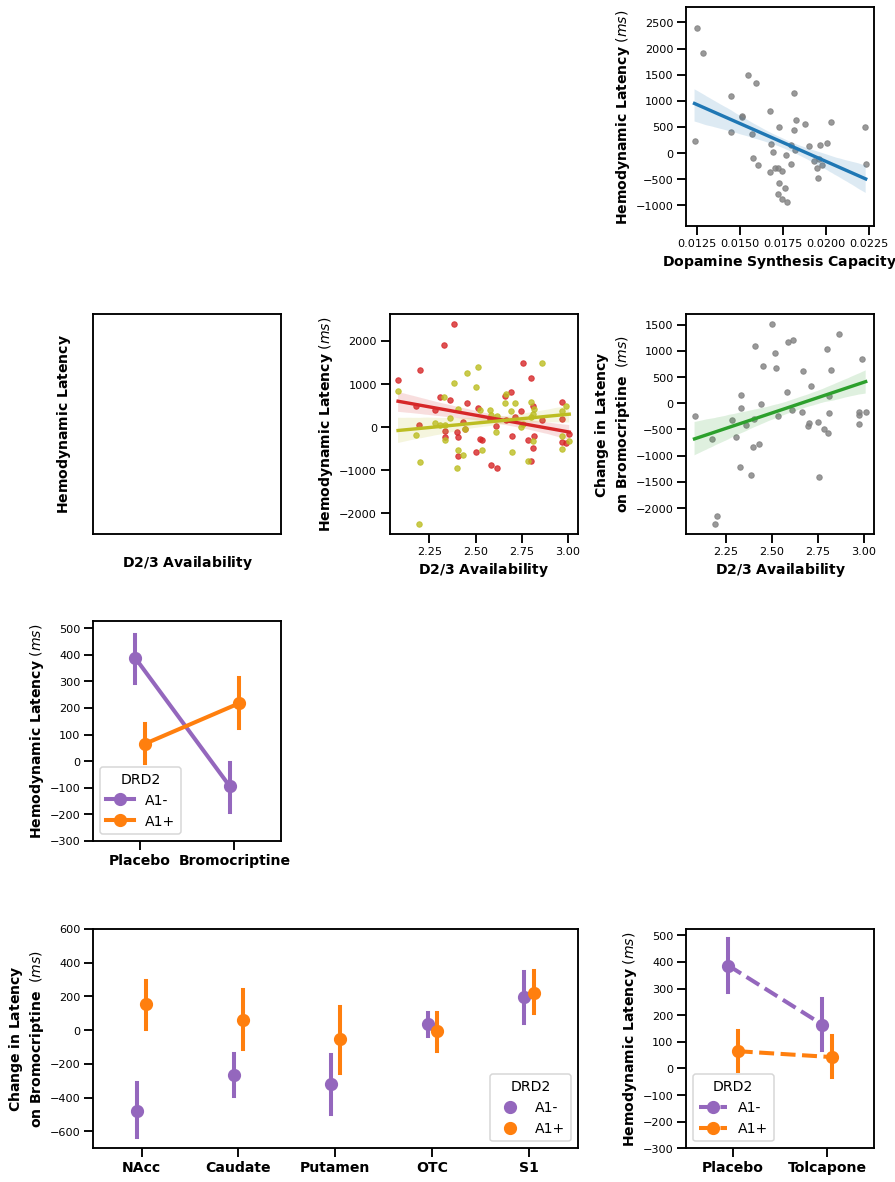

In [55]:
#plotting settings
fontsize = 14
ticksize = fontsize*.8
figy = 4
width = 16
sns.set_context('talk')
plt.rcParams['legend.title_fontsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize


fig = plt.figure(
                figsize=(14,21))#layout="constrained",
widths = [1,1,1,1,1,1]

gs = GridSpec(4, 6, 
              figure=fig,
              width_ratios=widths,
              hspace = .4,
              wspace = 2.7)

ax1 = fig.add_subplot(gs[0, 0:4])
ax2 = fig.add_subplot(gs[0, 4:])
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:])
ax6 = fig.add_subplot(gs[2, 0:2])
ax7 = fig.add_subplot(gs[2, 2:])
ax8 = fig.add_subplot(gs[3, 0:4])
ax9 = fig.add_subplot(gs[3, 4:])

for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]:
    ax.tick_params(labelsize=ticksize)
    ax.xaxis.get_label().set_fontsize(fontsize)
    ax.yaxis.get_label().set_fontsize(fontsize)

    
##################
####Top Right######
##################
plac_df = lags[lags['Drug'] == 'Placebo']
vst_df = plac_df[plac_df['roi'] == 'VST']

sns.regplot(x = 'fmt',
             y = 'lag',
            scatter_kws={'s':30,
                       'color':'grey'},
            color = sns.color_palette()[0],
              ci = 68,
           ax = ax2,
             data=vst_df)
ax2.set(ylabel = '$\\bf{Hemodynamic\ Latency}$ $\it{(ms)}$',
            xlabel = '$\\bf{Dopamine\ Synthesis\ Capacity}$')
ax2.set_ylim([-1400, 2800])

##################
####Second Left######
##################
sns.regplot(x = 'rac',
             y = 'lag',
            scatter_kws={'s':30,
                         'alpha':.8,
                        'color':sns.color_palette()[3]},
            color = sns.color_palette()[3],
              ci = 68,
            ax = ax4,
             data=vst_df)

brom_df = lags[lags['Drug'] == 'Bromocriptine']
vst_df_brom = brom_df[brom_df['roi'] == 'VST']

sns.regplot(x = 'rac',
             y = 'lag',
            scatter_kws={'s':30,
                         'alpha':.8,
                        'color':sns.color_palette()[8]},
            color = sns.color_palette()[8],
              ci = 68,
            ax = ax4,
             data=vst_df_brom)

ax4.set(ylabel = '$\\bf{Hemodynamic\ Latency}$ $\it{(ms)}$',
            xlabel = '$\\bf{D2/3\ Availability}$')

##################
####Second Middle######
##################
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set(ylabel = '$\\bf{Hemodynamic\ Latency}$')
ax3.set(xlabel = '$\\bf{D2/3\ Availability}$')
ax3.xaxis.labelpad = 20
ax3.yaxis.labelpad = 20

##################
####Second Right######
##################
brom_df = drug_diff[drug_diff['Drug'] == 'Bromocriptine']
vst_df_diff = brom_df[brom_df['roi'] == 'VST']

sns.regplot(x = 'rac',
             y = 'lag_diff',
            scatter_kws={'s':30,
                       'color':'grey'},
            color = sns.color_palette()[2],
              ci = 68,
           ax = ax5,
             data=vst_df_diff)
ax5.set(ylabel = '$\\bf{Change\ in\ Latency}$\n$\\bf{on\ Bromocriptine\ }$ $\it{(ms)}$',
            xlabel = '$\\bf{D2/3\ Availability}$')

##################
####third Left######
##################
plac= lags[lags['drug'] != 'tolc']
plac= lags[lags['roi'] == 'VST']


sns.pointplot(x = 'Drug',
             y = 'lag_within',
              hue = 'DRD2',
            order = ['Placebo','Bromocriptine'],
              errorbar=('ci', 68),
              dodge = .1,
            palette = [sns.color_palette()[4],sns.color_palette()[1]],
                   ax = ax6,
             data=plac)

ax6.set(ylabel = '$\\bf{Hemodynamic\ Latency}$ $\it{(ms)}$',
            xlabel = '')
ax6.set_ylim([-300, 525])
ax6.tick_params(axis = 'x',
                    labelsize=fontsize)
ax6.xaxis.get_label().set_fontsize(ticksize)
labels = ax6.get_xticklabels()
for l in labels:
    l.set_fontweight('bold')
    l.set_fontsize(fontsize)

##################
####Top Right######
##################
sns.pointplot(x = 'roi',
             y = 'brom_diff',
             hue = 'DRD2',
              hue_order = ['A1-','A1+'],
              errorbar=('ci', 68),
              linestyle='none',
                          palette = [sns.color_palette()[4],sns.color_palette()[1]],
              order = ['NAcc','Caudate','Putamen','OTC','S1'],
              dodge = .1,
              ax = ax8,
             data = means_df)
ax8.set(ylabel = '$\\bf{Change\ in\ Latency}$\n$\\bf{on\ Bromocriptine\ }$ $\it{(ms)}$',
            xlabel = '')
ax8.tick_params(axis = 'x',
                    labelsize=fontsize)
ax8.set_ylim([-700, 600])

labels = ax8.get_xticklabels()
for l in labels:
    l.set_fontweight('bold')
    l.set_fontsize(fontsize)
    
##################
####Saving########
##################
plac= lags[lags['drug'] != 'brom']
plac= lags[lags['roi'] == 'VST']


sns.pointplot(x = 'Drug',
             y = 'lag_within',
              hue = 'DRD2',
            order = ['Placebo','Tolcapone'],
              errorbar=('ci', 68),
              linestyle = '--',
              dodge = .1,
            palette = [sns.color_palette()[4],sns.color_palette()[1]],
                   ax = ax9,
             data=plac)
ax9.set_ylim([-300, 525])

ax9.set(ylabel = '$\\bf{Hemodynamic\ Latency}$ $\it{(ms)}$',
            xlabel = '')
ax9.tick_params(axis = 'x',
                    labelsize=fontsize)
labels = ax9.get_xticklabels()
for l in labels:
    l.set_fontweight('bold')
    l.set_fontsize(fontsize)
        

ax1.axis('off')
ax7.axis('off')


plt.subplots_adjust(hspace = .7,
                   wspace= .7)
plt.savefig('../figs/paper/fig2_figs.png',
                            bbox_inches = 'tight',
            dpi = 600)

In [56]:
model_lags = lags[lags['roi'] == 'VST'].dropna(subset = ['lag','DRD2'])

md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*C(DRD2,Sum)", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Mixed Linear Model Regression Results
========================================================================================================
Model:                             MixedLM                Dependent Variable:                lag        
No. Observations:                  219                    Method:                            REML       
No. Groups:                        73                     Scale:                             431600.5369
Min. group size:                   3                      Log-Likelihood:                    -1720.3393 
Max. group size:                   3                      Converged:                         Yes        
Mean group size:                   3.0                                                                  
--------------------------------------------------------------------------------------------------------
                                                         Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                                 225.861   88.099  2.564 0.010   53.190 398.532
C(drug, Treatment('plac'))[T.brom]                       -164.087  108.833 -1.508 0.132 -377.397  49.222
C(drug, Treatment('plac'))[T.tolc]                       -122.106  108.833 -1.122 0.262 -335.415  91.203
C(DRD2, Sum)[S.A1+]                                      -160.984   88.099 -1.827 0.068 -333.656  11.687
C(drug, Treatment('plac'))[T.brom]:C(DRD2, Sum)[S.A1+]    316.328  108.833  2.907 0.004  103.019 529.637
C(drug, Treatment('plac'))[T.tolc]:C(DRD2, Sum)[S.A1+]    100.016  108.833  0.919 0.358 -113.293 313.326
Group Var                                              134030.062   86.952                              
========================================================================================================

"""

In [70]:
model_lags = lags.dropna(subset = ['lag','DRD2']).copy()

md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*C(DRD2,Sum)*C(roi, Treatment('VST'))", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                  Mixed Linear Model Regression Results
==========================================================================================================================================
Model:                                       MixedLM                            Dependent Variable:                            lag        
No. Observations:                            1095                               Method:                                        REML       
No. Groups:                                  73                                 Scale:                                         412664.6519
Min. group size:                             15                                 Log-Likelihood:                                -8504.3998 
Max. group size:                             15                                 Converged:                                     Yes        
Mean group size:                             15.0                                                                                         
------------------------------------------------------------------------------------------------------------------------------------------
                                                                                          Coef.   Std.Err.   z    P>|z|   [0.025   0.975] 
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                 225.861   81.048  2.787 0.005    67.009  384.713
C(drug, Treatment('plac'))[T.brom]                                                       -164.087  106.419 -1.542 0.123  -372.665   44.490
C(drug, Treatment('plac'))[T.tolc]                                                       -122.106  106.419 -1.147 0.251  -330.684   86.471
C(DRD2, Sum)[S.A1+]                                                                      -160.984   81.048 -1.986 0.047  -319.836   -2.133
C(roi, Treatment('VST'))[T.DCA]                                                          -341.614  106.419 -3.210 0.001  -550.192 -133.037
C(roi, Treatment('VST'))[T.DPUT]                                                         -828.250  106.419 -7.783 0.000 -1036.828 -619.673
C(roi, Treatment('VST'))[T.OT]                                                           -179.385  106.419 -1.686 0.092  -387.962   29.193
C(roi, Treatment('VST'))[T.S1]                                                           -748.800  106.419 -7.036 0.000  -957.377 -540.222
C(drug, Treatment('plac'))[T.brom]:C(DRD2, Sum)[S.A1+]                                    316.328  106.419  2.972 0.003   107.750  524.905
C(drug, Treatment('plac'))[T.tolc]:C(DRD2, Sum)[S.A1+]                                    100.016  106.419  0.940 0.347  -108.561  308.594
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DCA]                         61.480  150.499  0.409 0.683  -233.493  356.453
C(drug, Treatment('plac'))[T.tolc]:C(roi, Treatment('VST'))[T.DCA]                        -84.611  150.499 -0.562 0.574  -379.584  210.362
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DPUT]                       -22.745  150.499 -0.151 0.880  -317.719  272.228
C(drug, Treatment('plac'))[T.tolc]:C(roi, Treatment('VST'))[T.DPUT]                       -20.710  150.499 -0.138 0.891  -315.683  274.263
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.OT]                         176.982  150.499  1.176 0.240  -117.992  471.955
C(drug, Treatment('plac'))[T.tolc]:C(roi, Treatment('VST'))[T.OT]                          21.453  150.499  0.143 0.887  -273.520  316.426
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.S1]                         370.620  150.499  2.463 0.014    75.647  665.593
C(drug, Treatment('plac'))[T.tolc]:C(roi, Treatment('VST'))[T.S1]                         278.507  150.499  1.

## COMT

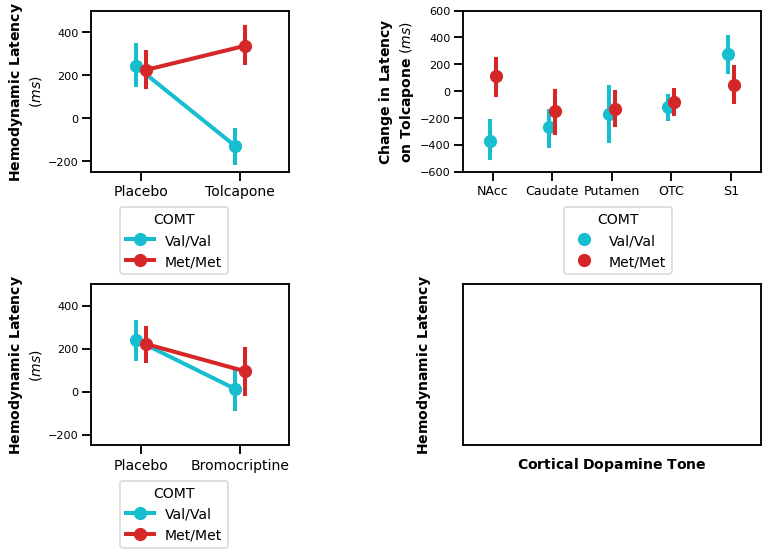

In [78]:
#plotting settings
fontsize = 14
ticksize = fontsize*.8
figy = 4
width = 16
sns.set_context('talk')
plt.rcParams['legend.title_fontsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize


fig,ax=plt.subplots(2,2,
                    figsize=(12,8),
                    width_ratios=[1, 1.5],
                    sharex=False,
                    sharey=False)
for i in range(2):
    for j in range(2):
        ax[i][j].tick_params(labelsize=ticksize)
        ax[i][j].xaxis.get_label().set_fontsize(fontsize)
        ax[i][j].yaxis.get_label().set_fontsize(fontsize)

##################
####Top Left######
##################
plac= lags[lags['drug'] != 'tolc']
plac= lags[lags['roi'] == 'VST']


sns.pointplot(x = 'Drug',
             y = 'lag_within',
              hue = 'COMT',
            order = ['Placebo','Tolcapone'],
                          hue_order = ['Val/Val','Met/Met'],
              errorbar=('ci', 68),
              dodge = .1,
            palette = [sns.color_palette()[9],sns.color_palette()[3]],
                   ax = ax[0][0],
             data=plac)
ax[0,0].set_ylim([-250, 500])
ax[0][0].set(ylabel = '$\\bf{Hemodynamic\ Latency}$\n$\it{(ms)}$',
            xlabel = '')
ax[0][0].tick_params(axis = 'x',
                    labelsize=fontsize)
ax[0][0].xaxis.get_label().set_fontsize(ticksize)
sns.move_legend(ax[0][0], "upper right",bbox_to_anchor=(.725,-.175))


##################
####Top Right######
##################
sns.pointplot(x = 'roi',
             y = 'tolc_diff',
             hue = 'COMT',
              errorbar=('ci', 68),
              linestyle='none',
                            hue_order = ['Val/Val','Met/Met'],
            palette = [sns.color_palette()[9],sns.color_palette()[3]],
              order = ['NAcc','Caudate','Putamen','OTC','S1'],
              dodge = .1,
              ax = ax[0][1],
             data = means_df)
ax[0][1].set(ylabel = '$\\bf{Change\ in\ Latency}$\n$\\bf{on\ Tolcapone\ }$$\it{(ms)}$',
            xlabel = '')
ax[0][1].tick_params(axis = 'x',
                    labelsize=fontsize*.9)
ax[0,1].set_ylim([-600, 600])
sns.move_legend(ax[0][1], "upper right",bbox_to_anchor=(.725,-.175))




##################
####Bottom Left####
##################
plac= lags[lags['drug'] != 'tolc']
plac= lags[lags['roi'] == 'VST']
sns.pointplot(x = 'Drug',
             y = 'lag_within',
              hue = 'COMT',
              hue_order = ['Val/Val','Met/Met'],
            order = ['Placebo','Bromocriptine'],
              errorbar=('ci', 68),
              dodge = .1,
            palette = [sns.color_palette()[9],sns.color_palette()[3]],
                   ax = ax[1][0],
             data=plac)

ax[1][0].set(ylabel = '$\\bf{Hemodynamic\ Latency}$\n$\it{(ms)}$',
            xlabel = '')
ax[1][0].tick_params(axis = 'x',
                    labelsize=fontsize)
ax[1][0].xaxis.get_label().set_fontsize(ticksize)
sns.move_legend(ax[1][0], "upper right",bbox_to_anchor=(.725,-.175))
ax[1,0].set_ylim([-250, 500])


ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].set(ylabel = '$\\bf{Hemodynamic\ Latency}$')
ax[1,1].set(xlabel = '$\\bf{Cortical\ Dopamine\ Tone}$')
ax[1,1].yaxis.labelpad = 30
ax[1,1].xaxis.labelpad = 10
##################
####Saving########
##################

plt.subplots_adjust(hspace = .7,
                   wspace= .7)
plt.savefig('../figs/paper/fig2_figs_Supplement.png',
                            bbox_inches = 'tight',
            dpi = 300)

In [59]:
model_lags = lags[lags['roi'] == 'VST'].dropna(subset = ['lag','COMT'])

md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*C(COMT,Sum)", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Mixed Linear Model Regression Results
============================================================================================================
Model:                             MixedLM                  Dependent Variable:                  lag        
No. Observations:                  219                      Method:                              REML       
No. Groups:                        73                       Scale:                               441689.9174
Min. group size:                   3                        Log-Likelihood:                      -1721.0189 
Max. group size:                   3                        Converged:                           Yes        
Mean group size:                   3.0                                                                      
------------------------------------------------------------------------------------------------------------
                                                             Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                                     232.609   87.978  2.644 0.008   60.176 405.042
C(drug, Treatment('plac'))[T.brom]                           -177.780  110.015 -1.616 0.106 -393.407  37.846
C(drug, Treatment('plac'))[T.tolc]                           -129.532  110.015 -1.177 0.239 -345.158  86.094
C(COMT, Sum)[S.Met/Met]                                        -9.649   87.978 -0.110 0.913 -182.082 162.784
C(drug, Treatment('plac'))[T.brom]:C(COMT, Sum)[S.Met/Met]     50.622  110.015  0.460 0.645 -165.004 266.248
C(drug, Treatment('plac'))[T.tolc]:C(COMT, Sum)[S.Met/Met]    242.002  110.015  2.200 0.028   26.376 457.628
Group Var                                                  123227.166   83.650                              
============================================================================================================

"""

In [76]:
model_lags = lags[lags['roi'] == 'VST'].dropna(subset = ['lag','COMT'])

md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*C(COMT,Sum) + C(drug, Treatment('plac'))*C(DRD2,Sum)", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Mixed Linear Model Regression Results
============================================================================================================
Model:                             MixedLM                  Dependent Variable:                  lag        
No. Observations:                  219                      Method:                              REML       
No. Groups:                        73                       Scale:                               420763.1582
Min. group size:                   3                        Log-Likelihood:                      -1700.4197 
Max. group size:                   3                        Converged:                           Yes        
Mean group size:                   3.0                                                                      
------------------------------------------------------------------------------------------------------------
                                                             Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                                     225.966   87.218  2.591 0.010   55.021 396.911
C(drug, Treatment('plac'))[T.brom]                           -164.746  107.469 -1.533 0.125 -375.382  45.890
C(drug, Treatment('plac'))[T.tolc]                           -125.544  107.469 -1.168 0.243 -336.179  85.092
C(COMT, Sum)[S.Met/Met]                                        -7.354   87.153 -0.084 0.933 -178.170 163.462
C(DRD2, Sum)[S.A1+]                                          -160.879   87.218 -1.845 0.065 -331.824  10.065
C(drug, Treatment('plac'))[T.brom]:C(COMT, Sum)[S.Met/Met]     46.119  107.388  0.429 0.668 -164.358 256.597
C(drug, Treatment('plac'))[T.tolc]:C(COMT, Sum)[S.Met/Met]    240.625  107.388  2.241 0.025   30.147 451.102
C(drug, Treatment('plac'))[T.brom]:C(DRD2, Sum)[S.A1+]        315.669  107.469  2.937 0.003  105.033 526.305
C(drug, Treatment('plac'))[T.tolc]:C(DRD2, Sum)[S.A1+]         96.579  107.469  0.899 0.369 -114.057 307.214
Group Var                                                  133499.104   87.369                              
============================================================================================================

"""

In [77]:
model_lags = lags.dropna(subset = ['lag','COMT']).copy()

md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*C(COMT,Sum)*C(roi, Treatment('VST'))", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                    Mixed Linear Model Regression Results
==============================================================================================================================================
Model:                                         MixedLM                             Dependent Variable:                             lag        
No. Observations:                              1095                                Method:                                         REML       
No. Groups:                                    73                                  Scale:                                          412027.5652
Min. group size:                               15                                  Log-Likelihood:                                 -8503.2263 
Max. group size:                               15                                  Converged:                                      Yes        
Mean group size:                               15.0                                                                                           
----------------------------------------------------------------------------------------------------------------------------------------------
                                                                                              Coef.   Std.Err.   z    P>|z|   [0.025   0.975] 
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                     232.609   80.845  2.877 0.004    74.156  391.062
C(drug, Treatment('plac'))[T.brom]                                                           -177.780  106.257 -1.673 0.094  -386.040   30.479
C(drug, Treatment('plac'))[T.tolc]                                                           -129.532  106.257 -1.219 0.223  -337.791   78.728
C(COMT, Sum)[S.Met/Met]                                                                        -9.649   80.845 -0.119 0.905  -168.101  148.804
C(roi, Treatment('VST'))[T.DCA]                                                              -346.896  106.257 -3.265 0.001  -555.156 -138.637
C(roi, Treatment('VST'))[T.DPUT]                                                             -828.828  106.257 -7.800 0.000 -1037.088 -620.569
C(roi, Treatment('VST'))[T.OT]                                                               -185.123  106.257 -1.742 0.081  -393.383   23.137
C(roi, Treatment('VST'))[T.S1]                                                               -760.972  106.257 -7.162 0.000  -969.231 -552.712
C(drug, Treatment('plac'))[T.brom]:C(COMT, Sum)[S.Met/Met]                                     50.622  106.257  0.476 0.634  -157.638  258.882
C(drug, Treatment('plac'))[T.tolc]:C(COMT, Sum)[S.Met/Met]                                    242.002  106.257  2.278 0.023    33.742  450.262
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DCA]                             68.504  150.270  0.456 0.648  -226.020  363.028
C(drug, Treatment('plac'))[T.tolc]:C(roi, Treatment('VST'))[T.DCA]                            -79.149  150.270 -0.527 0.598  -373.673  215.375
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DPUT]                           -16.725  150.270 -0.111 0.911  -311.249  277.799
C(drug, Treatment('plac'))[T.tolc]:C(roi, Treatment('VST'))[T.DPUT]                           -22.467  150.270 -0.150 0.881  -316.991  272.057
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.OT]                             189.764  150.270  1.263 0.207  -104.760  484.288
C(drug, Treatment('plac'))[T.tolc]:C(roi, Treatment('VST'))[T.OT]                              27.962  150.270  0.186 0.852  -266.562  322.486
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.S1]                             387.315  150.270  2.577 0.010    92.791  681.839


# pet analyses

In [71]:
model_lags = lags[lags['roi'] == 'VST'].dropna(subset = ['fmt'])

model_lags['fmt'] = model_lags['fmt'] - np.mean(model_lags['fmt'])  

md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*fmt", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
================================================================================================
Model:                         MixedLM              Dependent Variable:              lag        
No. Observations:              132                  Method:                          REML       
No. Groups:                    44                   Scale:                           399741.8357
Min. group size:               3                    Log-Likelihood:                  -996.2750  
Max. group size:               3                    Converged:                       Yes        
Mean group size:               3.0                                                              
------------------------------------------------------------------------------------------------
                                          Coef.     Std.Err.   z    P>|z|    [0.025     0.975]  
------------------------------------------------------------------------------------------------
Intercept                                  217.894   106.741  2.041 0.041       8.687    427.102
C(drug, Treatment('plac'))[T.brom]         -90.320   134.796 -0.670 0.503    -354.516    173.876
C(drug, Treatment('plac'))[T.tolc]        -279.615   134.796 -2.074 0.038    -543.812    -15.419
fmt                                    -145288.767 48762.893 -2.979 0.003 -240862.281 -49715.253
C(drug, Treatment('plac'))[T.brom]:fmt   66569.639 61579.857  1.081 0.280  -54124.662 187263.940
C(drug, Treatment('plac'))[T.tolc]:fmt   66615.434 61579.857  1.082 0.279  -54078.867 187309.735
Group Var                               101573.718    99.260                                    
================================================================================================

"""

In [72]:
model_lags = lags[lags['roi'] == 'VST'].dropna(subset = ['rac'])

model_lags['rac'] = model_lags['rac'] - np.mean(model_lags['rac'])  

md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*rac", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
==========================================================================================
Model:                       MixedLM            Dependent Variable:            lag        
No. Observations:            132                Method:                        REML       
No. Groups:                  44                 Scale:                         372613.7484
Min. group size:             3                  Log-Likelihood:                -1010.6797 
Max. group size:             3                  Converged:                     Yes        
Mean group size:             3.0                                                          
------------------------------------------------------------------------------------------
                                         Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
------------------------------------------------------------------------------------------
Intercept                                 217.894  108.924  2.000 0.045     4.406  431.382
C(drug, Treatment('plac'))[T.brom]        -90.320  130.142 -0.694 0.488  -345.394  164.754
C(drug, Treatment('plac'))[T.tolc]       -279.615  130.142 -2.149 0.032  -534.689  -24.541
rac                                      -769.193  445.941 -1.725 0.085 -1643.221  104.836
C(drug, Treatment('plac'))[T.brom]:rac   1176.135  532.808  2.207 0.027   131.850 2220.420
C(drug, Treatment('plac'))[T.tolc]:rac   -199.557  532.808 -0.375 0.708 -1243.842  844.727
Group Var                              149424.151  119.806                                
==========================================================================================

"""

In [64]:
model_lags = lags[lags['roi'] == 'VST'].dropna(subset = ['rac2'])

model_lags['rac2'] = model_lags['rac2'] - np.mean(model_lags['rac2'])  

md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*rac2", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
=========================================================================================
Model:                        MixedLM           Dependent Variable:           lag        
No. Observations:             132               Method:                       REML       
No. Groups:                   44                Scale:                        398250.1978
Min. group size:              3                 Log-Likelihood:               -1022.3069 
Max. group size:              3                 Converged:                    Yes        
Mean group size:              3.0                                                        
-----------------------------------------------------------------------------------------
                                          Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------------------------
Intercept                                  217.894  111.612  1.952 0.051   -0.862 436.650
C(drug, Treatment('plac'))[T.brom]         -90.320  134.545 -0.671 0.502 -354.023 173.383
C(drug, Treatment('plac'))[T.tolc]        -279.615  134.545 -2.078 0.038 -543.318 -15.913
rac2                                        -0.666   30.166 -0.022 0.982  -59.791  58.459
C(drug, Treatment('plac'))[T.brom]:rac2    -43.295   36.365 -1.191 0.234 -114.568  27.978
C(drug, Treatment('plac'))[T.tolc]:rac2     -0.282   36.365 -0.008 0.994  -71.555  70.991
Group Var                               149872.311  119.695                              
=========================================================================================

"""

In [73]:
# model_lags = lags.dropna(subset = ['fmt'])
model_lags = lags[lags['drug'] != 'tolc'].dropna(subset = ['fmt'])

model_lags['fmt'] = model_lags['fmt'] - np.mean(model_lags['fmt'])        
md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*C(roi,Treatment('VST'))*fmt", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                              Mixed Linear Model Regression Results
=================================================================================================================================
Model:                                    MixedLM                         Dependent Variable:                         lag        
No. Observations:                         264                             Method:                                     REML       
No. Groups:                               44                              Scale:                                      411282.2480
Min. group size:                          6                               Log-Likelihood:                             -1999.6737 
Max. group size:                          6                               Converged:                                  Yes        
Mean group size:                          6.0                                                                                    
---------------------------------------------------------------------------------------------------------------------------------
                                                                           Coef.     Std.Err.   z    P>|z|    [0.025     0.975]  
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  -215.741   186.058 -1.160 0.246    -580.408    148.926
C(drug, Treatment('plac'))[T.brom]                                           99.113   224.250  0.442 0.659    -340.409    538.634
C(roi, Treatment('VST'))[T.DCA]                                             204.188   198.046  1.031 0.303    -183.976    592.352
C(roi, Treatment('VST'))[T.DPUT]                                           -542.789   309.222 -1.755 0.079   -1148.853     63.275
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DCA]         -422.691   272.638 -1.550 0.121    -957.052    111.670
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DPUT]         250.267   361.845  0.692 0.489    -458.936    959.471
fmt                                                                     -152386.192 50989.707 -2.989 0.003 -252324.181 -52448.203
C(drug, Treatment('plac'))[T.brom]:fmt                                    66569.639 62462.427  1.066 0.287  -55854.469 188993.746
C(roi, Treatment('VST'))[T.DCA]:fmt                                      230414.854 66931.622  3.443 0.001   99231.285 361598.424
C(roi, Treatment('VST'))[T.DPUT]:fmt                                     190588.367 63841.777  2.985 0.003   65460.783 315715.952
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DCA]:fmt  -268054.845 93481.749 -2.867 0.004 -451275.707 -84833.983
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DPUT]:fmt -197400.880 89332.843 -2.210 0.027 -372490.035 -22311.725
Group Var                                                                185538.448    95.135                                    
=================================================================================================================================

"""

In [75]:
model_lags = lags[lags['drug'] != 'tolc'].dropna(subset = ['rac'])

model_lags['rac'] = model_lags['rac'] - np.mean(model_lags['rac'])        
md = smf.mixedlm("lag ~ C(drug, Treatment('plac'))*C(roi,Treatment('VST'))*rac", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Mixed Linear Model Regression Results
===========================================================================================================================
Model:                                  MixedLM                       Dependent Variable:                       lag        
No. Observations:                       264                           Method:                                   REML       
No. Groups:                             44                            Scale:                                    444404.2381
Min. group size:                        6                             Log-Likelihood:                           -2037.0749 
Max. group size:                        6                             Converged:                                Yes        
Mean group size:                        6.0                                                                                
---------------------------------------------------------------------------------------------------------------------------
                                                                          Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 -213.916  276.747 -0.773 0.440  -756.329  328.498
C(drug, Treatment('plac'))[T.brom]                                         554.360  349.180  1.588 0.112  -130.021 1238.741
C(roi, Treatment('VST'))[T.DCA]                                            166.037  285.260  0.582 0.561  -393.062  725.136
C(roi, Treatment('VST'))[T.DPUT]                                          -475.790  430.838 -1.104 0.269 -1320.217  368.637
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DCA]        -703.964  384.634 -1.830 0.067 -1457.833   49.905
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DPUT]       -542.117  524.912 -1.033 0.302 -1570.926  486.692
rac                                                                       -787.781  455.569 -1.729 0.084 -1680.679  105.117
C(drug, Treatment('plac'))[T.brom]:rac                                    1176.135  581.876  2.021 0.043    35.679 2316.591
C(roi, Treatment('VST'))[T.DCA]:rac                                       1088.219  554.713  1.962 0.050     1.002 2175.436
C(roi, Treatment('VST'))[T.DPUT]:rac                                       902.094  570.343  1.582 0.114  -215.758 2019.947
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DCA]:rac   -1425.151  767.897 -1.856 0.063 -2930.201   79.899
C(drug, Treatment('plac'))[T.brom]:C(roi, Treatment('VST'))[T.DPUT]:rac  -1422.786  781.395 -1.821 0.069 -2954.292  108.719
Group Var                                                               181812.554   92.481                                
===========================================================================================================================

"""

In [69]:
model_lags = lags[lags['roi'] == 'VST'].dropna(subset = ['rac'])
model_lags = model_lags[model_lags['drug'] == 'plac']
md = smf.ols("rac ~ C(DRD2, Sum)", model_lags, 
                 groups=model_lags["sub"]).fit()
md.summary()

/Users/ianballard/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rac   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7011
Date:                Sat, 25 Jan 2025   Prob (F-statistic):              0.407
Time:                        17:57:52   Log-Likelihood:              -0.049587
No. Observations:                  44   AIC:                             4.099
Df Residuals:                      42   BIC:                             7.668
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.5841      0.038     68.488      0.000       2.508       2.660
C(DRD2, Sum)[S.A1+]    -0.0316      0.038     -0.837      0.407      -0.108       0.045
==============================================================================
Omnibus:                        4.130   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.127   Jarque-Bera (JB):                1.795
Skew:                          -0.057   Prob(JB):                        0.408
Kurtosis:                       2.017   Cond. No.                         1.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""